# **Blood Cell Cancer Classification Using InceptionV3 and Advanced Segmentation**

## Project Overview
### Objective
Develop an automated system for classifying blood cell images to detect cancer using deep learning and advanced image processing techniques.

### Dataset

- **Source**: Blood Cell Cancer [ALL] dataset
- **Classes**: 4 categories
  - Benign (Normal cells)
  - [Malignant] Early Pre-B
  - [Malignant] Pre-B
  - [Malignant] Pro-B


- **Total Images**: ~3000+ samples
- **Split**: 90% training, 10% testing

#### Methodology
Combines traditional computer vision (segmentation) with modern deep learning (MobileNetV2) for enhanced classification accuracy.


## Environment Setup

#### Step 1: Install Required Libraries


In [ ]:
# !pip install imutils : is used to install the imutils package, which simplifies common image processing tasks with OpenCV.
# such as resizing, rotating, and displaying images.

!pip install imutils

#### Step 2: Import Essential Libraries

In [ ]:
# This code block imports all the essential libraries for deep learning, image preprocessing, clustering, and model evaluation.
# It prepares the environment for training transfer learning models such as InceptionV3 and DenseNet201 on image data.

from imutils import paths
import os
import numpy as np
import random
import pandas as pd
from sklearn.model_selection import train_test_split

import cv2
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
from skimage import morphology
import time

import keras,math
from keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D,BatchNormalization
from keras.layers import Dense, Dropout
from keras.models import Model

import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import regularizers
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn import metrics
from tensorflow.keras.applications import InceptionV3, MobileNetV2
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.mixed_precision import set_global_policy
import itertools

#### Step 3: Configuration Settings

**Why these settings?**

- Mixed precision reduces training time while maintaining accuracy
- Random seeds ensure reproducible results
- 224x224 is optimal for MobileNetV2 input
- Batch size of 64 balances memory usage and training speed

In [ ]:
# Enable mixed precision for faster training
set_global_policy('mixed_float16')

# Set random seeds for reproducibility
np.random.seed(88)
tf.random.set_seed(88)
random.seed(88)

# Configuration
BATCH_SIZE = 64  # Increased batch size for faster training
IMG_SIZE = (224, 224)
IMG_SHAPE = (224, 224, 3)
SPLIT = 0.90
PREFETCH_BUFFER = tf.data.AUTOTUNE

## Data Loading and Preparation

#### Step 1: Mount Google Drive and Set Paths & Load and Shuffle Data

In [ ]:
'''
This code
1.mounts Google Drive,
2. loads all image paths from a dataset folder,
3. shuffles them for randomness,
4. then splits them into training and testing sets using a 90/10 ratio.
It's a standard data preparation step for building a deep learning model using medical image data.

'''

from google.colab import drive
drive.mount('/content/drive')

# Define the path to the dataset directory in Google Drive
data_dir = '/content/drive/MyDrive/Blood cell Cancer [ALL]'

from imutils import paths
import random
from sklearn.model_selection import train_test_split

# List all image file paths in the dataset directory and sort them
data_list = sorted(list(paths.list_images(data_dir)))


random.seed(88)            # Set a seed to ensure reproducibility of the shuffl
random.shuffle(data_list)  # Shuffle the list of image paths randomly

# Split the dataset into training and testing sets
train_list, test_list = train_test_split(
    data_list,            # Use the shuffled image paths
    train_size=0.90,      # 90% for training
    shuffle=True,         # Shuffle before splitting
    random_state=88       # Set random seed for reproducibility
    )

print('Number of training images:', len(train_list))
print('Number of testing images:', len(test_list))



Mounted at /content/drive
Number of training images: 2917
Number of testing images: 325


In [ ]:
# Show the full file paths of the testing images.

test_list

['/content/drive/MyDrive/Blood cell Cancer [ALL]/[Malignant] Pre-B/Snap_819.jpg',
 '/content/drive/MyDrive/Blood cell Cancer [ALL]/[Malignant] early Pre-B/Snap_136 - Copy.jpg',
 '/content/drive/MyDrive/Blood cell Cancer [ALL]/[Malignant] early Pre-B/Snap_233 - Copy.jpg',
 '/content/drive/MyDrive/Blood cell Cancer [ALL]/[Malignant] Pre-B/Snap_146.jpg',
 '/content/drive/MyDrive/Blood cell Cancer [ALL]/[Malignant] Pre-B/Snap_259.jpg',
 '/content/drive/MyDrive/Blood cell Cancer [ALL]/[Malignant] early Pre-B/Snap_235 - Copy.jpg',
 '/content/drive/MyDrive/Blood cell Cancer [ALL]/[Malignant] Pro-B/Snap_161.jpg',
 '/content/drive/MyDrive/Blood cell Cancer [ALL]/[Malignant] Pre-B/Snap_289.jpg',
 '/content/drive/MyDrive/Blood cell Cancer [ALL]/Benign/Snap_072 (3).jpg',
 '/content/drive/MyDrive/Blood cell Cancer [ALL]/[Malignant] Pre-B/Snap_300.jpg',
 '/content/drive/MyDrive/Blood cell Cancer [ALL]/[Malignant] early Pre-B/Snp_147 (145).jpg',
 '/content/drive/MyDrive/Blood cell Cancer [ALL]/[Malig

#### Step 2: Analyze Dataset Distribution


In [ ]:
'''
Prints the total number of images in the dataset.
Then displays the number of images in each class (Benign, and three Malignant subtypes).
It's useful for checking class balance before training a model.

'''

print('Number of samples in dataset:',len(list(paths.list_images(data_dir))),'\n')

print('Number of samples in each class:','\n')
print("#1 Benign ---------------:", len(list(paths.list_images(f"{data_dir}/Benign"))))
print("#2 Malignant[Early PreB] :", len(list(paths.list_images(f"{data_dir}/[Malignant] early Pre-B"))))
print("#3 Malignant[PreB] ------:", len(list(paths.list_images(f"{data_dir}/[Malignant] Pre-B"))))
print("#4 Malignant[ProB] ------:", len(list(paths.list_images(f"{data_dir}/[Malignant] Pro-B"))))

Number of samples in dataset: 3242 

Number of samples in each class: 

#1 Benign ---------------: 512
#2 Malignant[Early PreB] : 979
#3 Malignant[PreB] ------: 955
#4 Malignant[ProB] ------: 796


#### Dataset Statistics
The dataset contains blood cell images across four categories:

- **Benign**: Normal blood cells:
- **Malignant [Early Pre-B]**: Early stage malignant cells
- **Malignant [Pre-B]**: Pre-B malignant cells
- **Malignant [Pro-B]**: Pro-B malignant cells

#### Key Metrics:
- Total training images: ~2,600+ samples
- Total testing images: ~290+ samples
- Image format: Various (JPEG, PNG)
- Target size: 224×224 pixels

#### Key Insights:
- Understand class imbalance
- Plan stratified sampling
- Determine augmentation needs

## Advanced Image Segmentation

#### Step 1: Create Output Directories

In [ ]:
import os

# Define the root directory inside Google Drive where all folders will be created
base_dir = '/content/drive/MyDrive/prepared_dataset'

# List of relative subfolder paths for training and testing data, organized by class
train_dirs = [
    'prepared_data/benign',
    'prepared_data/PreB',
    'prepared_data/ProB',
    'prepared_data/EarlyPreB',
    'prepared_test/benign',
    'prepared_test/PreB',
    'prepared_test/ProB',
    'prepared_test/EarlyPreB'
]

# إنشاء المجلدات
for d in train_dirs:
    dir_path = os.path.join(base_dir, d)   # Combine base path with the subfolder path
    os.makedirs(dir_path, exist_ok=True)   # Create the directory if it doesn't already exist

print("✅ All folders created successfully inside Google Drive.")

✅ All folders created successfully inside Google Drive.


#### Step 2: Process Test Data

In [ ]:
# import cv2
# import os

# p = 0                                     # Initialize counter for naming saved images

# for img in test_list:                     # Loop through each image path in the test dataset
#     i = cv2.imread(img)                   # Read the image using OpenCV
#     i = cv2.resize(i, (224, 224))         # Resize image to 224x224 (standard size for CNN models)

#     # Extract the class label from the parent folder name
#     lable = os.path.basename(os.path.dirname(img))

#     # Choose the destination path based on the label
#     if lable == "Benign":
#         b = f'{base_dir}/prepared_test/benign/{lable}_{p}.png'
#     elif lable == "[Malignant] Pre-B":
#         b = f'{base_dir}/prepared_test/PreB/{lable}_{p}.png'
#     elif lable == "[Malignant] Pro-B":
#         b = f'{base_dir}/prepared_test/ProB/{lable}_{p}.png'
#     elif lable == "[Malignant] early Pre-B":
#         b = f'{base_dir}/prepared_test/EarlyPreB/{lable}_{p}.png'
#     else:
#         # If label doesn't match expected values
#         print(f"❗ Unknown label found: {lable}")
#         continue        # Skip the image

#     cv2.imwrite(b, i)   # Save the resized image to the target folder
#     p += 1              # Increment the counter for the next image


#### Step 3: Process Training Data with Segmentation and apply Segmentation Algorithm Implementation
The segmentation process follows these key steps:
-  Color Space Conversion
-  K-Means Clustering
-  Binary Thresholding
-  Morphological Operations
-  Complete Segmentation Pipeline


In [ ]:
# p=0                                                     # Initialize a counter for image naming
# tic = time.perf_counter()

# for img in train_list:                                  # Loop through each image path in the training dataset

#     i= cv2.imread(img)                                  # Read the image using OpenCV
#     i= cv2.resize(i,(224,224))                          # Resize image to 224x224 pixels
#     lable = os.path.basename(os.path.dirname(img))      # Extract class label from parent folder name

#     if (lable=="Benign"):
#         b= (f'{base_dir}/prepared_data/benign/'+lable+str(p)+'.png')
#     if (lable=="[Malignant] Pre-B"):
#         b= (f'{base_dir}/prepared_data/PreB/'+lable+str(p)+'.png')
#     if (lable=="[Malignant] Pro-B"):
#         b= (f'{base_dir}/prepared_data/ProB/'+lable+str(p)+'.png')
#     if (lable=="[Malignant] early Pre-B"):
#         b= (f'{base_dir}/prepared_data/EarlyPreB/'+lable+str(p)+'.png')
#     p+=1                # Increment counter
#     cv2.imwrite(b,i)    # Save the resized image

#     #-------- Segmentation ---------
#     i= cv2.cvtColor(i, cv2.COLOR_BGR2RGB)             # Convert BGR to RGB
#     i_lab = cv2.cvtColor(i, cv2.COLOR_RGB2LAB)        # Convert RGB to LAB color space
#     l,a,b = cv2.split(i_lab)                          # Split LAB channels
#     i2 = a.reshape(a.shape[0]*a.shape[1],1)           # Flatten the 'a' channel for clustering
#     km= KMeans(n_clusters=7, random_state=0).fit(i2)  # Apply KMeans clustering on 'a' channel
#     p2s= km.cluster_centers_[km.labels_]              # Get clustered pixel values
#     ic= p2s.reshape(a.shape[0],a.shape[1])            # Reshape back to image shape
#     ic = ic.astype(np.uint8)
#     r,t = cv2.threshold(ic,141,255 ,cv2.THRESH_BINARY)# Apply binary threshold
#     fh = ndi.binary_fill_holes(t)                     # Fill holes inside the segmented region
#     m1 = morphology.remove_small_objects(fh, 200)     # Remove small noise
#     m2 = morphology.remove_small_holes(m1,250)        # Remove small holes
#     m2 = m2.astype(np.uint8)
#     out = cv2.bitwise_and(i, i, mask=m2)              # Apply segmentation mask to original image

#     if (lable=="Benign"):
#         b= (f'{base_dir}/prepared_data/benign/'+lable+str(p)+'.png')
#     if (lable=="[Malignant] Pre-B"):
#         b= (f'{base_dir}/prepared_data/PreB/'+lable+str(p)+'.png')
#     if (lable=="[Malignant] Pro-B"):
#         b= (f'{base_dir}/prepared_data/ProB/'+lable+str(p)+'.png')
#     if (lable=="[Malignant] early Pre-B"):
#         b= (f'{base_dir}/prepared_data/EarlyPreB/'+lable+str(p)+'.png')
#     p+=1                                             # Increment counter
#     out= cv2.cvtColor(out, cv2.COLOR_RGB2BGR)        # Convert back to BGR for saving
#     cv2.imwrite(b,out)                               # Save segmented image

# toc2 = time.perf_counter()                           # End the timer
# print(f"2917 samples processed in { ((toc2 - tic)/60) } minutes")

#### Step 4: Visualization of Segmentation Steps

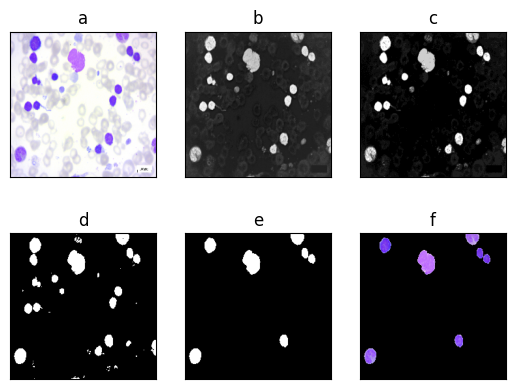

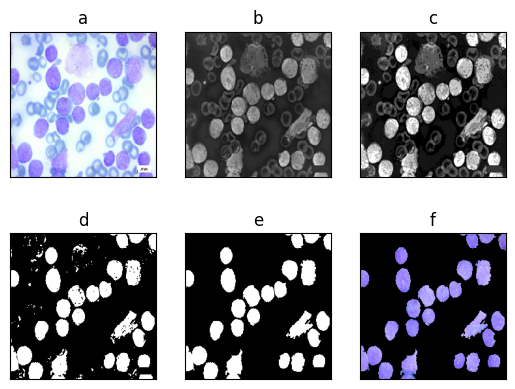

In [ ]:
#----- print some samples of training dataset -------

n= 3

o_img=[]
a_img=[]
c_img=[]
b_img=[]
m_img=[]
out_img=[]

random.seed(865)
random.shuffle(data_list)

for img in data_list[:n]:
    i= cv2.imread(img)
    i= cv2.cvtColor(i, cv2.COLOR_BGR2RGB)
    i= cv2.resize(i,(224,224))
    o_img.append(i)
    i_lab = cv2.cvtColor(i, cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(i_lab)
    a_img.append(a)
    i2 = a.reshape(a.shape[0]*a.shape[1],1)
    km= KMeans(n_clusters=7, random_state=0).fit(i2)
    p2s= km.cluster_centers_[km.labels_]
    ic= p2s.reshape(a.shape[0],a.shape[1])
    ic = ic.astype(np.uint8)
    c_img.append(ic)
    r,t = cv2.threshold(ic,141,255 ,cv2.THRESH_BINARY)
    b_img.append(t)
    fh = ndi.binary_fill_holes(t)
    m1 = morphology.remove_small_objects(fh, 200)
    m2 = morphology.remove_small_holes(m1,250)
    #m2 = ndi.binary_fill_holes(m2)
    #m1 = m1.astype(np.uint8)
    #m1_imgs.append(m1)
    m2 = m2.astype(np.uint8)
    m_img.append(m2)
    out = cv2.bitwise_and(i, i, mask=m2)
    out_img.append(out)

for j in range(n):
    for t in range(1):
        #print('=>',j+1,':')
        plt.subplot(2,3,1+t),plt.imshow(o_img[j])
        plt.title('a'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,2+t),plt.imshow(a_img[j],'gray')
        plt.title('b'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,3+t),plt.imshow(c_img[j],'gray')
        plt.title('c'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,4+t),plt.imshow(b_img[j],'gray')
        plt.title('d'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,5+t),plt.imshow(m_img[j],'gray')
        plt.title('e'),plt.xticks([]),plt.yticks([])
        plt.subplot(2,3,6+t),plt.imshow(out_img[j])
        plt.title('f'),plt.xticks([]),plt.yticks([])
    plt.show()

## Dataset Processing

#### Step 1: Optimized Image Preprocessing


In [ ]:
def preprocess_image(image_path, target_size=(224, 224)):
    """
    Preprocess single image with optimizations
    """
    # Read image
    image = cv2.imread(image_path)
    if image is None:
        return None

    # Convert BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize image
    image = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)

    # Normalize to [0,1]
    image = image.astype(np.float32) / 255.0

    return image

In [ ]:
def load_and_preprocess_image(image_path):
    """
    Fast image loading and preprocessing using TensorFlow ops
    """
    # Read image file
    image = tf.io.read_file(image_path)

    # Decode image (supports JPEG, PNG, GIF, BMP)
    image = tf.image.decode_image(image, channels=3, expand_animations=False)

    # Convert to float32 and normalize
    image = tf.cast(image, tf.float32) / 255.0

    # Resize image
    image = tf.image.resize(image, [224, 224])

    # Ensure shape is set
    image.set_shape([224, 224, 3])

    return image

#### Step 2: Optimized Dataset Creation

In [ ]:
def create_dataset_from_dataframe(df, batch_size, shuffle=True, augment=False):
    """
    Create optimized tf.data.Dataset from DataFrame using native TF operations
    """
    # Create label encoder using actual labels from data
    unique_labels = sorted(df['labels'].unique())
    print(f"Creating dataset with labels: {unique_labels}")
    label_to_index = {label: idx for idx, label in enumerate(unique_labels)}

    # Convert labels to indices
    df_indexed = df.copy()
    df_indexed['label_idx'] = df_indexed['labels'].map(label_to_index)

    # Check for any unmapped labels
    if df_indexed['label_idx'].isna().any():
        unmapped_labels = df_indexed[df_indexed['label_idx'].isna()]['labels'].unique()
        print(f"Warning: Found unmapped labels: {unmapped_labels}")
        # Remove rows with unmapped labels
        df_indexed = df_indexed.dropna(subset=['label_idx'])

    # Create dataset from file paths
    file_paths = tf.constant(df_indexed['filenames'].values)
    labels = tf.constant(df_indexed['label_idx'].values, dtype=tf.int32)

    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    # Map loading function
    dataset = dataset.map(
        lambda path, label: (load_and_preprocess_image(path), tf.one_hot(label, len(unique_labels))),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Apply augmentation if needed
    if augment:
        dataset = dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle if needed
    if shuffle:
        dataset = dataset.shuffle(buffer_size=min(1000, len(df_indexed)))

    # Batch and prefetch
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset, unique_labels

#### Step 3: Data Augmentation
**Augmentation benefits:**

- Increases effective dataset size
- Improves model generalization
- Reduces overfitting
- Simulates real-world variations

In [ ]:
def augment_image(image, label):
    """
    Apply data augmentation
    """
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)

    # Random vertical flip
    image = tf.image.random_flip_up_down(image)

    # Random brightness
    image = tf.image.random_brightness(image, max_delta=0.1)

    # Random contrast
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)

    # Ensure values stay in [0,1]
    image = tf.clip_by_value(image, 0.0, 1.0)

    return image, label

#### Training and Validation Curves



In [ ]:
def tr_plot(tr_data, start_epoch):
    """Plot the training and validation data with enhanced styling"""
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    for i in range(start_epoch, Epoch_count):
        Epochs.append(i + 1)
    index_loss = np.argmin(vloss)  # epoch with the lowest validation loss
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label = 'best epoch= ' + str(index_loss + 1 + start_epoch)
    vc_label = 'best epoch= ' + str(index_acc + 1 + start_epoch)
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
    axes[0].plot(Epochs, tloss, 'r', label='Training loss')
    axes[0].plot(Epochs, vloss, 'g', label='Validation loss')
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s=150, c='blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot(Epochs, tacc, 'r', label='Training Accuracy')
    axes[1].plot(Epochs, vacc, 'g', label='Validation Accuracy')
    axes[1].scatter(index_acc + 1 + start_epoch, acc_highest, s=150, c='blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout()
    plt.show()

#### Confusion Matrix Plotting


In [ ]:
def plot_confusion_matrix(cm, target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """Plot confusion matrix with accuracy information"""
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    sns.set(style="dark")
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\nAccuracy={:0.4f}; Misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

#### Step 4: Create DataFrames and Datasets

In [ ]:
#------- Test DataFrame ---------
print("📋 Creating Test DataFrame...")

# Directory containing the prepared test images
prepared_test_path = f'{base_dir}/prepared_test/'

# Check if test directory exists
if not os.path.exists(prepared_test_path):
    print(f"❌ Error: Test directory does not exist: {prepared_test_path}")
    print("Please check the base_dir path and folder structure.")
else:
    print(f"✅ Test directory found: {prepared_test_path}")

# Get all image file paths in the test directory
test_filenames = sorted(list(paths.list_images(prepared_test_path)))
if not test_filenames:
    print("❌ No test images found!")
else:
    print(f"✅ Found {len(test_filenames)} test images")

random.shuffle(test_filenames)

# Extract labels by getting the parent folder name of each image
test_labels = [os.path.basename(os.path.dirname(path)) for path in test_filenames]

# Create test DataFrame
test_df = pd.DataFrame({
    'filenames': test_filenames,
    'labels': test_labels
})

print('-- Test DataFrame --')
print(test_df.head())
print('-- Number of samples in each label --')
print(test_df['labels'].value_counts())

📋 Creating Test DataFrame...
✅ Test directory found: /content/drive/MyDrive/prepared_dataset/prepared_test/
✅ Found 325 test images
-- Test DataFrame --
                                           filenames     labels
0  /content/drive/MyDrive/prepared_dataset/prepar...     benign
1  /content/drive/MyDrive/prepared_dataset/prepar...  EarlyPreB
2  /content/drive/MyDrive/prepared_dataset/prepar...  EarlyPreB
3  /content/drive/MyDrive/prepared_dataset/prepar...       PreB
4  /content/drive/MyDrive/prepared_dataset/prepar...  EarlyPreB
-- Number of samples in each label --
labels
EarlyPreB    111
PreB          93
ProB          78
benign        43
Name: count, dtype: int64


In [ ]:
#------- Train/Valid DataFrame -------
print("\n📋 Creating Train/Valid DataFrame...")

# Directory containing the prepared training/validation images
prepared_data_path = f'{base_dir}/prepared_data/'

# Check if training directory exists
if not os.path.exists(prepared_data_path):
    print(f"❌ Error: Training directory does not exist: {prepared_data_path}")
    print("Please check the base_dir path and folder structure.")
else:
    print(f"✅ Training directory found: {prepared_data_path}")

# Get all image file paths
train_valid_filenames = sorted(list(paths.list_images(prepared_data_path)))
if not train_valid_filenames:
    print("❌ No training images found!")
else:
    print(f"✅ Found {len(train_valid_filenames)} training images")

random.shuffle(train_valid_filenames)

# Extract class labels
train_valid_labels = [os.path.basename(os.path.dirname(path)) for path in train_valid_filenames]

# Create train/valid DataFrame
df = pd.DataFrame({
    'filenames': train_valid_filenames,
    'labels': train_valid_labels
})

print('-- Train/Valid DataFrame --')
print(df.head())
print('-- Number of samples in each label --')
label_counts = df['labels'].value_counts()
print(label_counts)


📋 Creating Train/Valid DataFrame...
✅ Training directory found: /content/drive/MyDrive/prepared_dataset/prepared_data/
✅ Found 5834 training images
-- Train/Valid DataFrame --
                                           filenames     labels
0  /content/drive/MyDrive/prepared_dataset/prepar...       PreB
1  /content/drive/MyDrive/prepared_dataset/prepar...  EarlyPreB
2  /content/drive/MyDrive/prepared_dataset/prepar...       ProB
3  /content/drive/MyDrive/prepared_dataset/prepar...  EarlyPreB
4  /content/drive/MyDrive/prepared_dataset/prepar...  EarlyPreB
-- Number of samples in each label --
labels
EarlyPreB    1736
PreB         1724
ProB         1436
benign        938
Name: count, dtype: int64


In [ ]:
# Display all unique labels
print(f"All unique labels in training data: {sorted(df['labels'].unique())}")
print(f"All unique labels in test data: {sorted(test_df['labels'].unique())}")

All unique labels in training data: ['EarlyPreB', 'PreB', 'ProB', 'benign']
All unique labels in test data: ['EarlyPreB', 'PreB', 'ProB', 'benign']


In [ ]:
# Get actual labels from the data
actual_labels = list(label_counts.index)
print(f"Actual labels found in data: {actual_labels}")

Actual labels found in data: ['EarlyPreB', 'PreB', 'ProB', 'benign']


In [ ]:
# Use actual labels for visualization
labels = actual_labels
values = [label_counts[label] for label in labels]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'][:len(labels)]

plt.figure(figsize=(10, 8))
sns.barplot(x=labels, y=values, palette=colors)
plt.title('Number of All the Data', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()

<ipython-input-24-830543836>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=labels, y=values, palette=colors)


In [ ]:
# Split dataset
print(f"\n🔄 Splitting dataset with ratio {SPLIT}...")
TRAIN_DF, VALID_DF = train_test_split(df, train_size=SPLIT, shuffle=True, random_state=88, stratify=df['labels'])

print(f'Train samples: {len(TRAIN_DF)}')
print(f'Valid samples: {len(VALID_DF)}')
print(f'Test samples: {len(test_df)}')


🔄 Splitting dataset with ratio 0.9...
Train samples: 5250
Valid samples: 584
Test samples: 325


#### Step 5: Create Optimized Datasets


In [ ]:
# Create optimized datasets
print("\n🚀 Creating optimized datasets...")

# Get all unique labels from both train and test data
all_train_labels = set(TRAIN_DF['labels'].unique())
all_test_labels = set(test_df['labels'].unique())
all_labels = sorted(list(all_train_labels.union(all_test_labels)))

print(f"All unique labels across datasets: {all_labels}")


🚀 Creating optimized datasets...
All unique labels across datasets: ['EarlyPreB', 'PreB', 'ProB', 'benign']


In [ ]:
# Create datasets using consistent labels
train_dataset, train_class_names = create_dataset_from_dataframe(TRAIN_DF, BATCH_SIZE, shuffle=True, augment=True)
valid_dataset, valid_class_names = create_dataset_from_dataframe(VALID_DF, BATCH_SIZE, shuffle=False, augment=False)
test_dataset, test_class_names = create_dataset_from_dataframe(test_df, BATCH_SIZE, shuffle=False, augment=False)


Creating dataset with labels: ['EarlyPreB', 'PreB', 'ProB', 'benign']
Creating dataset with labels: ['EarlyPreB', 'PreB', 'ProB', 'benign']
Creating dataset with labels: ['EarlyPreB', 'PreB', 'ProB', 'benign']


In [ ]:
# Use the most comprehensive class names
class_names = train_class_names  # Usually training set has all classes
print(f"Final class names: {class_names}")

Final class names: ['EarlyPreB', 'PreB', 'ProB', 'benign']


In [ ]:
# Verify consistency
print(f"Train classes: {train_class_names}")
print(f"Valid classes: {valid_class_names}")
print(f"Test classes: {test_class_names}")

Train classes: ['EarlyPreB', 'PreB', 'ProB', 'benign']
Valid classes: ['EarlyPreB', 'PreB', 'ProB', 'benign']
Test classes: ['EarlyPreB', 'PreB', 'ProB', 'benign']



🖼️ Displaying sample training images...


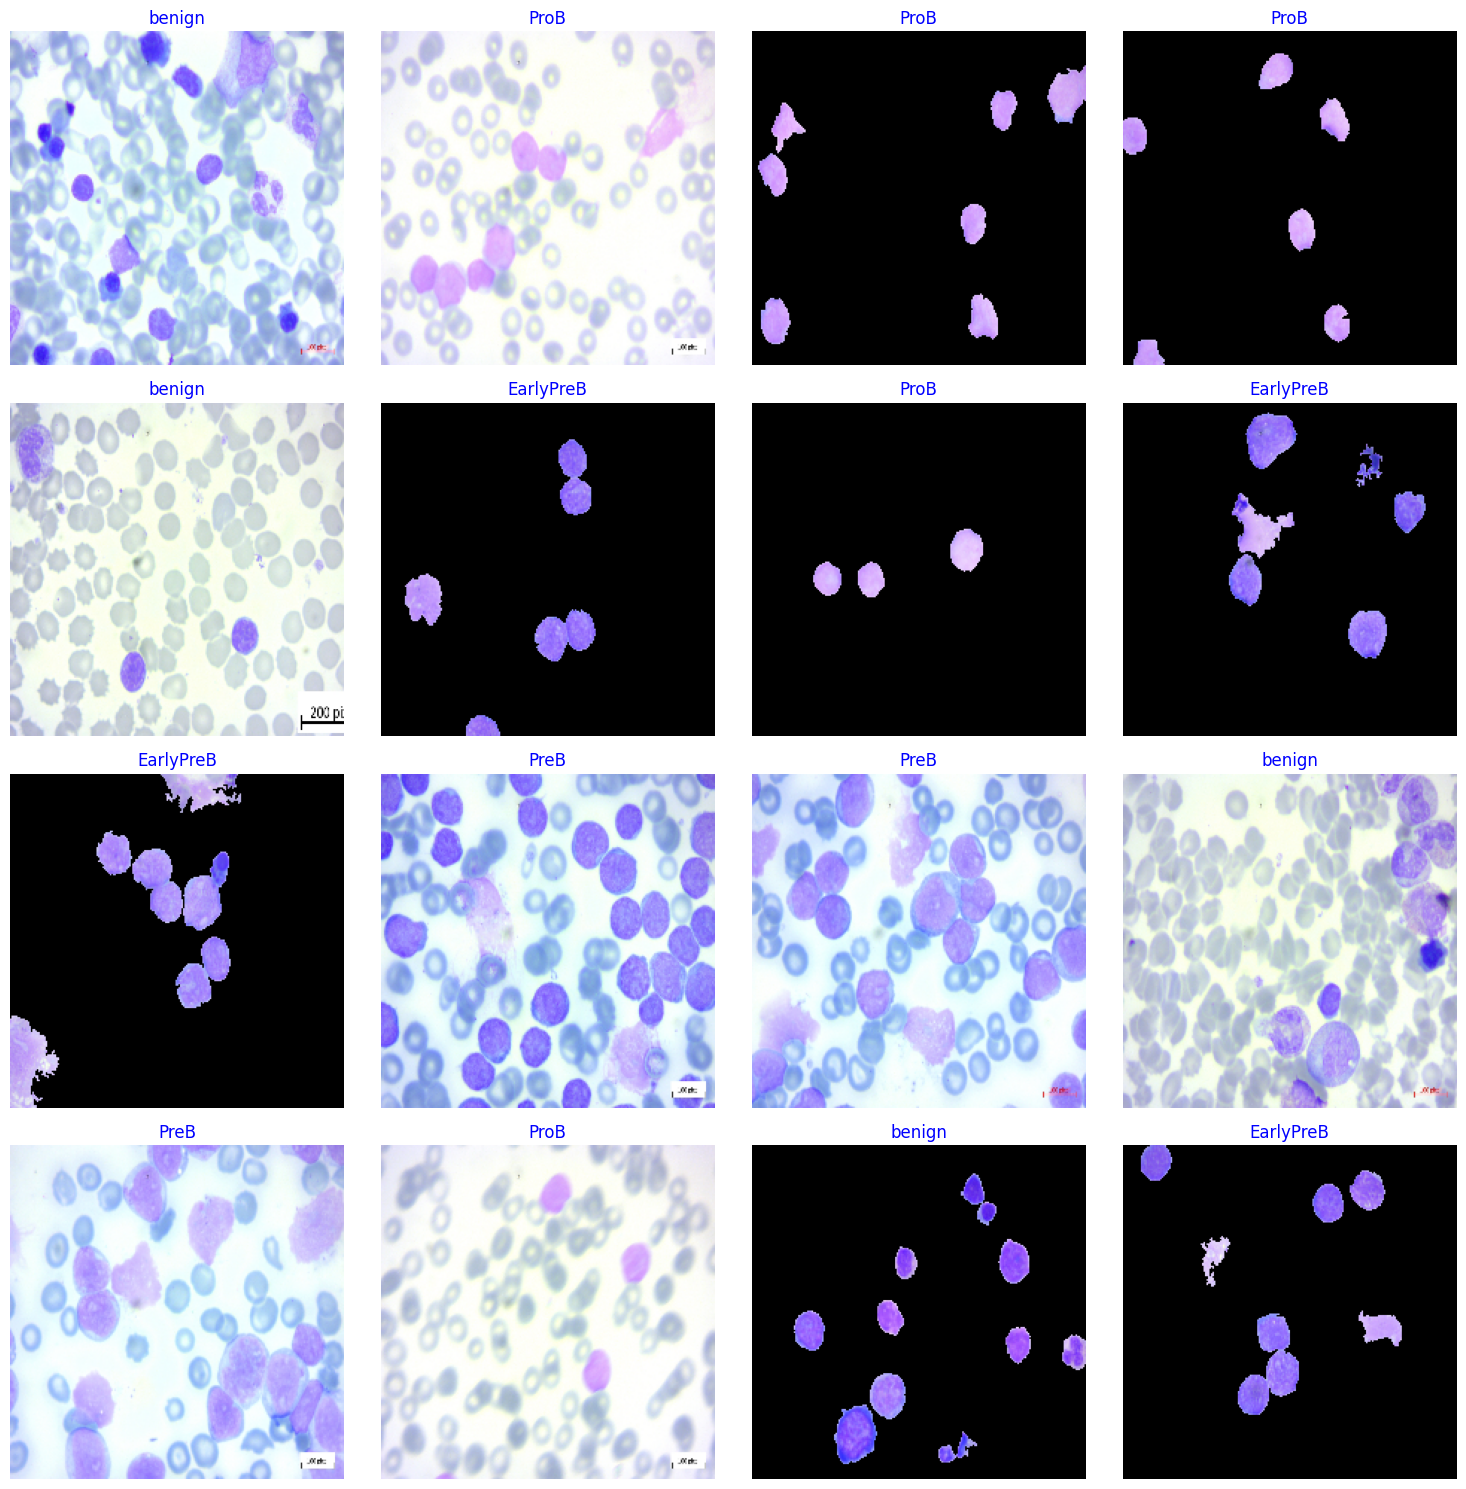

✅ Sample images displayed successfully!


In [ ]:
# Display sample images using traditional method (faster for preview)
print("\n🖼️ Displaying sample training images...")

# Take a small sample of files for quick preview
sample_files = TRAIN_DF.sample(n=16, random_state=88)

plt.figure(figsize=(15, 15))
for i, (idx, row) in enumerate(sample_files.iterrows()):
    if i >= 16:
        break

    plt.subplot(4, 4, i+1)

    # Quick image loading for preview
    img_path = row['filenames']
    try:
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (224, 224))
            plt.imshow(img)
            plt.title(row['labels'], color='blue', fontsize=12)
        else:
            plt.text(0.5, 0.5, 'Image\nNot Found', ha='center', va='center', transform=plt.gca().transAxes)
            plt.title(f"{row['labels']} (Error)", color='red', fontsize=12)
    except Exception as e:
        plt.text(0.5, 0.5, f'Error:\n{str(e)[:20]}...', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title(f"{row['labels']} (Error)", color='red', fontsize=12)

    plt.axis('off')

plt.tight_layout()
plt.show()
print("✅ Sample images displayed successfully!")

## Build and Compile InceptionV3 Model with Custom Head

In [ ]:
# Build InceptionV3 model
print("\n🏗️ Building InceptionV3 model...")
base_model = InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(224, 224, 3)
)

# Freeze the base model
base_model.trainable = False

# Add custom head
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(len(class_names), activation="softmax", dtype='float32')(x)  # Dynamic number of classes

model = Model(inputs=base_model.input, outputs=predictions)

print("Number of layers in the model:", len(model.layers))


🏗️ Building InceptionV3 model...
Number of layers in the model: 317


#### Cosine Decay Restarts Learning Rate Schedule &&  Compile the Model



In [ ]:
# Optimized learning rate schedule
initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.CosineDecayRestarts(
    initial_learning_rate,
    first_decay_steps=50,
    t_mul=2.0,
    m_mul=0.8,
    alpha=0.1
)

# Compile model with mixed precision
model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=lr_schedule, epsilon=1e-08),
    metrics=['accuracy']
)

print(f"InceptionV3 model built successfully! Total parameters: {model.count_params():,}")

InceptionV3 model built successfully! Total parameters: 22,074,276


## Training Pipeline

#### Step 1: Advanced Callbacks

In [ ]:
# Enhanced callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        'best_inception_model.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]


##### Step 2: Calculate Training Steps


In [ ]:
# Calculate steps per epoch
train_steps = len(TRAIN_DF) // BATCH_SIZE
valid_steps = len(VALID_DF) // BATCH_SIZE

print(f"Training steps per epoch: {train_steps}")
print(f"Validation steps per epoch: {valid_steps}")


Training steps per epoch: 82
Validation steps per epoch: 9


##### Step 3: Training Execution

In [ ]:
# Train model
print("\n🚀 Starting training...")
history = model.fit(
    train_dataset,
    epochs=10,  # Reduced epochs with better callbacks
    validation_data=valid_dataset,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks,
    verbose=1
)



🚀 Starting training...
Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.6892 - loss: 0.9410 
Epoch 1: val_accuracy improved from -inf to 0.82812, saving model to best_inception_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 1176s 11s/step - accuracy: 0.6903 - loss: 0.9375 - val_accuracy: 0.8281 - val_loss: 0.5316 - learning_rate: 6.5290e-04
Epoch 2/10
 1/82 ━━━━━━━━━━━━━━━━━━━━ 12:37 9s/step - accuracy: 1.0000 - loss: 0.0734

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy improved from 0.82812 to 0.82986, saving model to best_inception_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 39s 371ms/step - accuracy: 1.0000 - loss: 0.0734 - val_accuracy: 0.8299 - val_loss: 0.5302 - learning_rate: 6.4325e-04
Epoch 3/10
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.8853 - loss: 0.3345
Epoch 3: val_accuracy improved from 0.82986 to 0.84722, saving model to best_inception_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 40s 450ms/step - accuracy: 0.8852 - loss: 0.3346 - val_accuracy: 0.8472 - val_loss: 0.4076 - learning_rate: 6.6804e-04
Epoch 4/10
 1/82 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.1029
Epoch 4: val_accuracy did not improve from 0.84722
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 1.0000 - loss: 0.1029 - val_accuracy: 0.8455 - val_loss: 0.4065 - learning_rate: 6.6695e-04
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.8992 - loss: 0.2894
Epoch 5: val_accuracy improved from 0.84722 to 0.87326, saving model to best_inception_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 83s 482ms/step - accuracy: 0.8992 - loss: 0.2894 - val_accuracy: 0.8733 - val_loss: 0.3185 - learning_rate: 3.9705e-04
Epoch 6/10
 1/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5000 - loss: 1.9770
Epoch 6: val_accuracy did not improve from 0.87326
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5000 - loss: 1.9770 - val_accuracy: 0.8733 - val_loss: 0.3181 - learning_rate: 3.9705e-04
Epoch 7/10
81/82 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.9286 - loss: 0.2036
Epoch 7: val_accuracy improved from 0.87326 to 0.89410, saving model to best_inception_model.h5


82/82 ━━━━━━━━━━━━━━━━━━━━ 83s 536ms/step - accuracy: 0.9285 - loss: 0.2038 - val_accuracy: 0.8941 - val_loss: 0.2781 - learning_rate: 1.1410e-04
Epoch 8/10
 1/82 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5000 - loss: 2.6220
Epoch 8: val_accuracy did not improve from 0.89410
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5000 - loss: 2.6220 - val_accuracy: 0.8941 - val_loss: 0.2777 - learning_rate: 1.1273e-04
Epoch 9/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.9383 - loss: 0.1755
Epoch 9: val_accuracy did not improve from 0.89410
82/82 ━━━━━━━━━━━━━━━━━━━━ 54s 212ms/step - accuracy: 0.9381 - loss: 0.1759 - val_accuracy: 0.8889 - val_loss: 0.2964 - learning_rate: 5.3317e-04
Epoch 10/10
 1/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.1153
Epoch 10: val_accuracy did not improve from 0.89410
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 1.0000 - loss: 0.1153 - val_accuracy: 0.8872 - val_loss: 0.2969 - learning_rate: 5.3230e-04
Restoring

#### 📊 Enhanced Training History Plot



📊 Plotting enhanced training history...


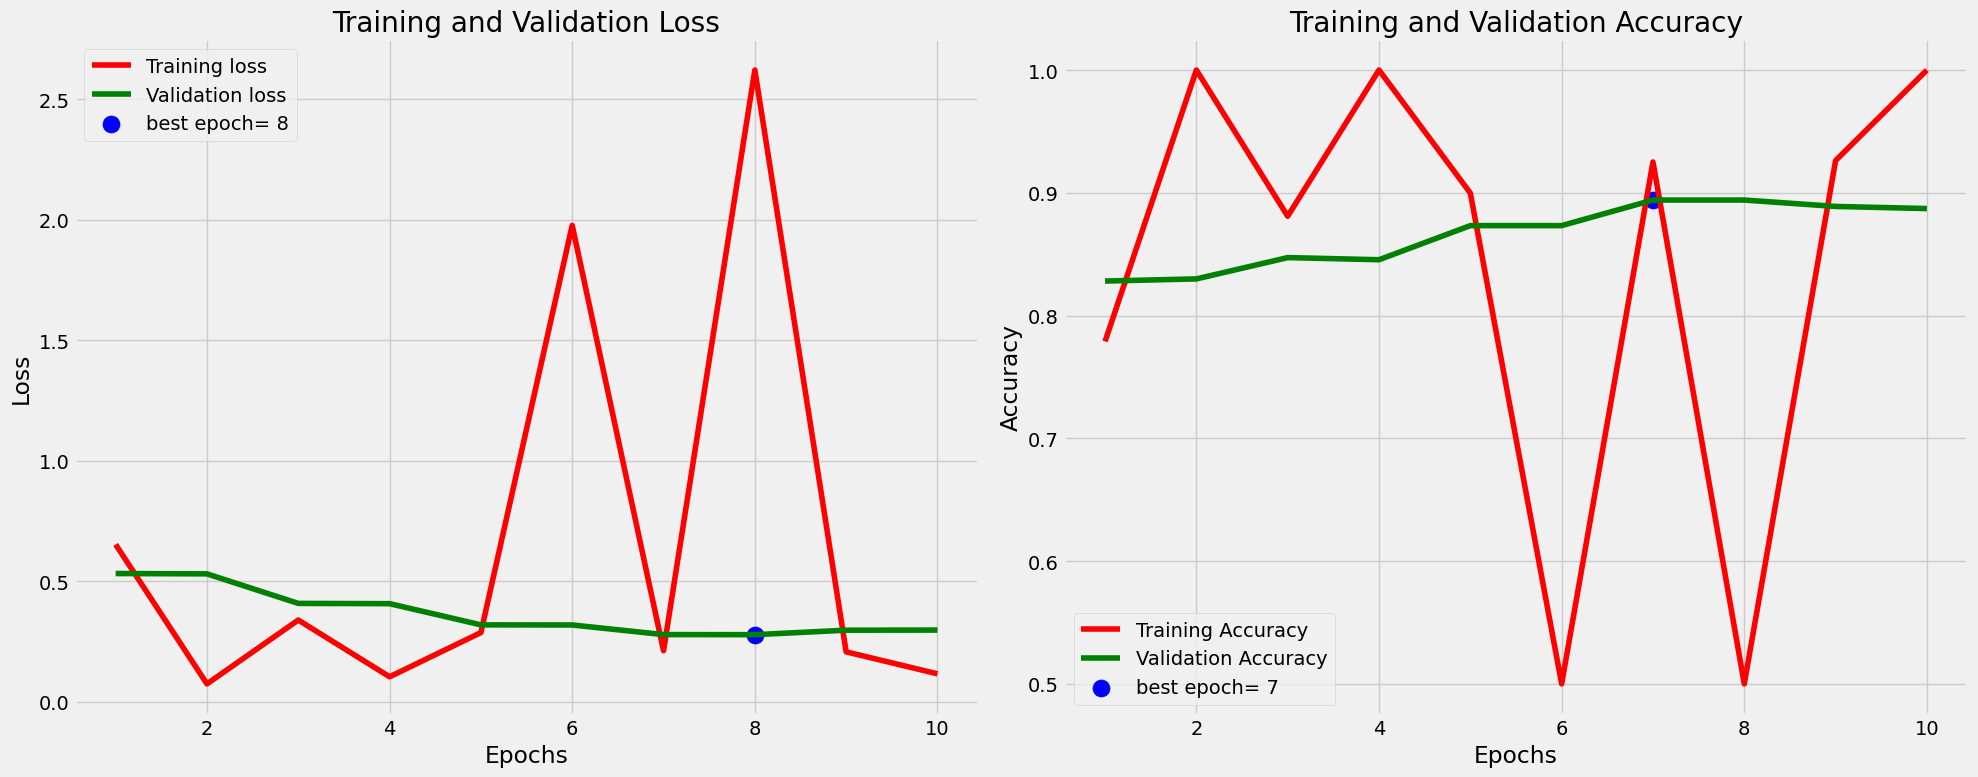

In [ ]:
# Plot enhanced training history
print("\n📊 Plotting enhanced training history...")
tr_plot(history, 0)


#### 📈 Basic Training and Validation Accuracy Plot && 📉 Basic Training and Validation Loss Plot


In [ ]:
# Additional basic plots
plt.figure(figsize=(10,5))
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.show()

## Evaluation and Results

#### Step 1: Test Set Evaluation

In [ ]:
# Evaluate on test set
print("\n📊 Evaluating on test set...")
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")


📊 Evaluating on test set...
6/6 ━━━━━━━━━━━━━━━━━━━━ 70s 11s/step - accuracy: 0.9355 - loss: 0.2120
✅ Test Accuracy: 92.92%


In [ ]:
# Enhanced message display
acc = test_accuracy * 100
msg = f'Model accuracy on test set: {acc:.2f}%'
print(f"\n🎯 {msg}")


🎯 Model accuracy on test set: 92.92%


#### Step 2: Detailed Predictions Analysis

In [ ]:
# Detailed predictions and analysis
print("\n🔍 Generating detailed predictions and analysis...")
predictions = model.predict(test_dataset, verbose=1)
predicted_classes = np.argmax(predictions, axis=1)


🔍 Generating detailed predictions and analysis...
6/6 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step


#### Step 3: Confusion Matrix Analysis


In [ ]:
# Get true labels from test dataset
true_classes = []
for _, labels in test_dataset:
    true_classes.extend(np.argmax(labels.numpy(), axis=1))
true_classes = np.array(true_classes[:len(predicted_classes)])

In [ ]:
# Calculate metrics
accuracy = metrics.accuracy_score(true_classes, predicted_classes)
print(f"Final Test Accuracy: {accuracy * 100:.2f}%")


Final Test Accuracy: 92.92%


In [ ]:
# Confusion Matrix Analysis
matrix = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:\n", matrix)

Confusion Matrix:
 [[106   1   0   4]
 [  4  88   1   0]
 [  1   0  77   0]
 [ 10   1   1  31]]


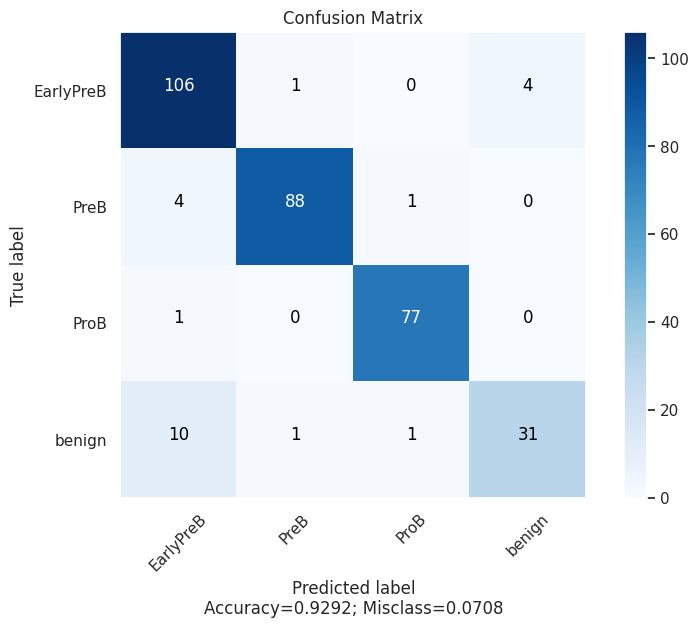

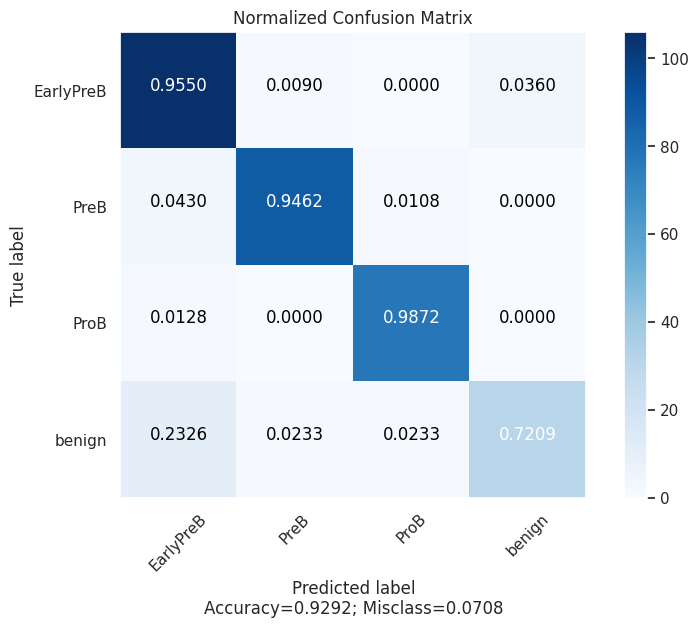

In [ ]:
# Plot confusion matrices
plot_confusion_matrix(matrix,
                      class_names,
                      normalize=False,
                      title="Confusion Matrix")

plot_confusion_matrix(matrix,
                      class_names,
                      normalize=True,
                      title="Normalized Confusion Matrix")

In [ ]:
# Calculate detailed metrics
TP = np.diag(matrix)
FP = matrix.sum(axis=0) - TP
FN = matrix.sum(axis=1) - TP
TN = matrix.sum() - (TP + FP + FN)

TPR = TP / (TP + FN)
TNR = TN / (TN + FP)
PPV = TP / (TP + FP)
NPV = TN / (TN + FN)
FPR = FP / (FP + TN)
FNR = FN / (TP + FN)
FDR = FP / (TP + FP)
ACC = (TP + TN) / (TP + FP + FN + TN)
MAE = mean_absolute_error(true_classes, predicted_classes)

print('\n📊 Detailed Metrics:')
print('MAE ----------------------------------------------:', MAE)
print('Accuracy -----------------------------------------:', ACC)
print('Precision (PPV) ----------------------------------:', PPV)
print('Recall (TPR) -------------------------------------:', TPR)
print('Specificity (TNR) -------------------------------:', TNR)
print('Negative Predictive Value ------------------------:', NPV)
print('Fall-out (FPR) -----------------------------------:', FPR)
print('False Negative Rate ------------------------------:', FNR)
print('False Discovery Rate -----------------------------:', FDR)

# Dice, IoU, Pixel Accuracy
dice = 2 * TP / (2 * TP + FP + FN + 1e-8)
iou = TP / (TP + FP + FN + 1e-8)
pixel_acc = np.sum(TP) / np.sum(matrix)

print(f"\n🎯 Pixel Accuracy (from Confusion Matrix): {pixel_acc:.4f}")
for i in range(len(class_names)):
    print(f"\nClass: {class_names[i]}")
    print(f"  TP={TP[i]}, FP={FP[i]}, FN={FN[i]}")
    print(f"  Dice Coefficient (F1): {dice[i]:.4f}")
    print(f"  Intersection over Union (IoU): {iou[i]:.4f}")


📊 Detailed Metrics:
MAE ----------------------------------------------: 0.16307692307692306
Accuracy -----------------------------------------: [0.93846154 0.97846154 0.99076923 0.95076923]
Precision (PPV) ----------------------------------: [0.87603306 0.97777778 0.97468354 0.88571429]
Recall (TPR) -------------------------------------: [0.95495495 0.94623656 0.98717949 0.72093023]
Specificity (TNR) -------------------------------: [0.92990654 0.99137931 0.99190283 0.9858156 ]
Negative Predictive Value ------------------------: [0.9754902  0.9787234  0.99593496 0.95862069]
Fall-out (FPR) -----------------------------------: [0.07009346 0.00862069 0.00809717 0.0141844 ]
False Negative Rate ------------------------------: [0.04504505 0.05376344 0.01282051 0.27906977]
False Discovery Rate -----------------------------: [0.12396694 0.02222222 0.02531646 0.11428571]

🎯 Pixel Accuracy (from Confusion Matrix): 0.9292

Class: EarlyPreB
  TP=106, FP=15, FN=5
  Dice Coefficient (F1): 0.9138
  

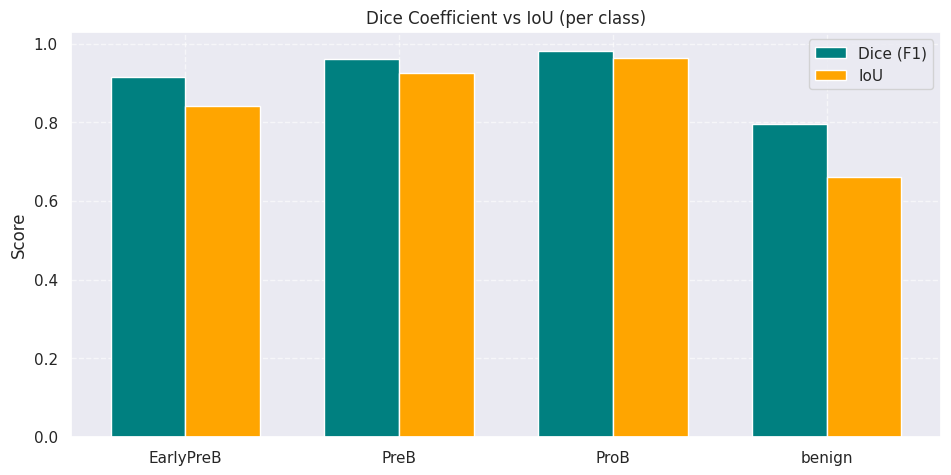

In [ ]:
# Plot Dice vs IoU
x = np.arange(len(class_names))
width = 0.35
plt.figure(figsize=(10, 5))
plt.bar(x - width/2, dice, width, label='Dice (F1)', color='teal')
plt.bar(x + width/2, iou, width, label='IoU', color='orange')
plt.xticks(x, class_names)
plt.ylabel("Score")
plt.title("Dice Coefficient vs IoU (per class)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

## Step 4: Classification Report


In [ ]:
# Classification report
print("\n📈 Classification Report:")
print(metrics.classification_report(
    true_classes,
    predicted_classes,
    target_names=class_names
))


📈 Classification Report:
              precision    recall  f1-score   support

   EarlyPreB       0.88      0.95      0.91       111
        PreB       0.98      0.95      0.96        93
        ProB       0.97      0.99      0.98        78
      benign       0.89      0.72      0.79        43

    accuracy                           0.93       325
   macro avg       0.93      0.90      0.91       325
weighted avg       0.93      0.93      0.93       325



In [ ]:
# Sample predictions visualization
print("\n🖼️ Visualizing sample predictions...")

# Convert test dataset to arrays for visualization
X_test = []
y_test = []
for images, labels in test_dataset.take(-1):  # Take all batches
    X_test.extend(images.numpy())
    y_test.extend(labels.numpy())

X_test = np.array(X_test)
y_test = np.array(y_test)

print('Shape of predictions: ', predictions.shape)
print('Shape of X_test: ', X_test.shape)
print('Shape of y_test: ', y_test.shape)


🖼️ Visualizing sample predictions...
Shape of predictions:  (325, 4)
Shape of X_test:  (325, 224, 224, 3)
Shape of y_test:  (325, 4)


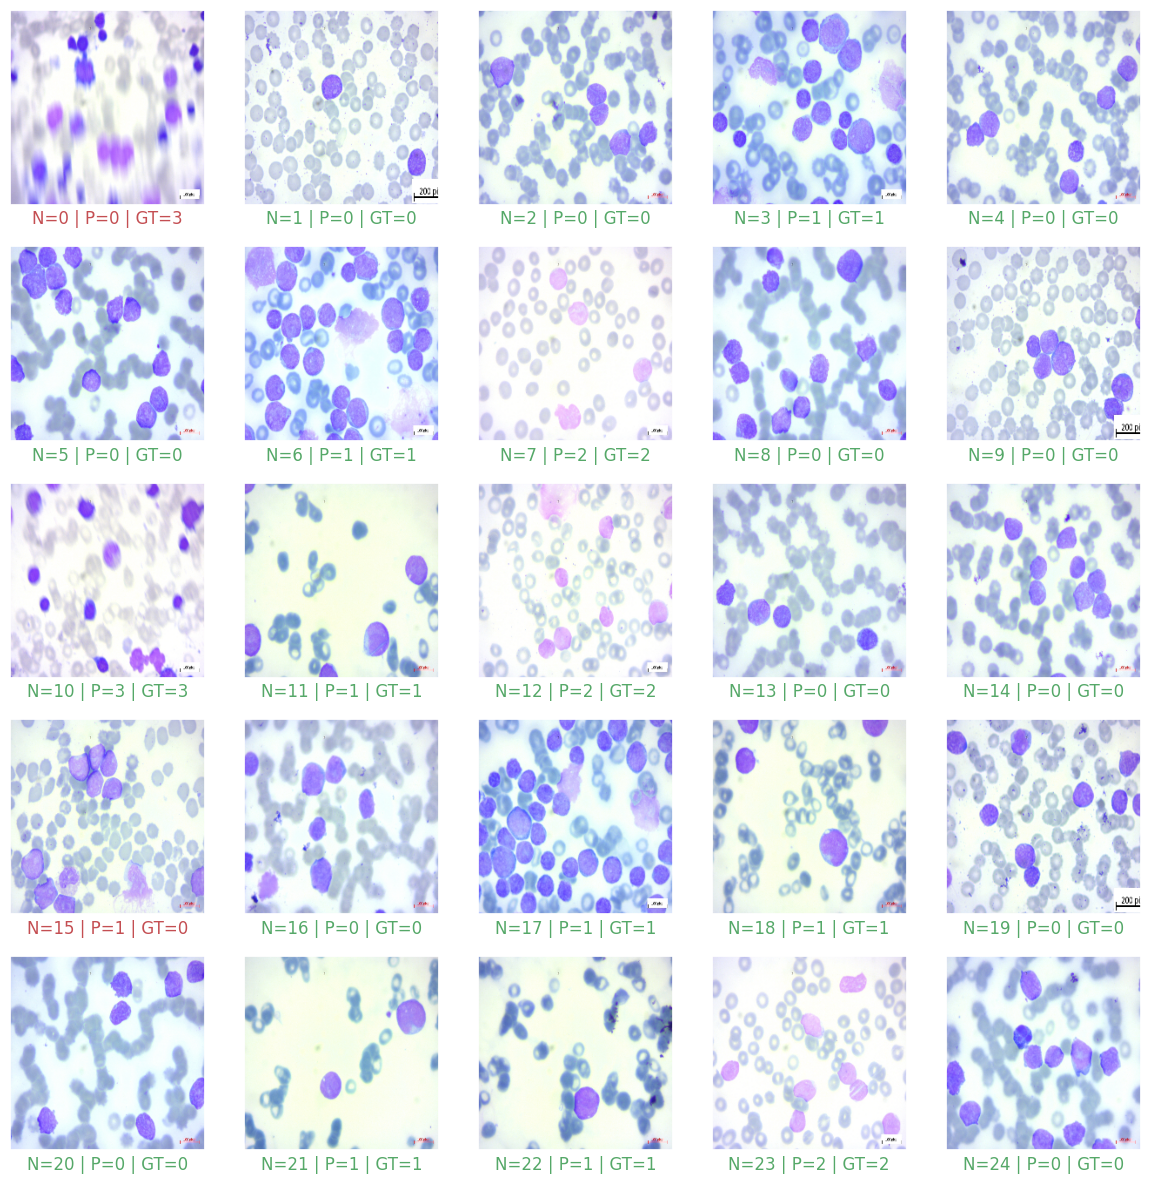

In [ ]:
# Visualize sample predictions
plt.figure(figsize=(12, 12))
for i in range(min(25, len(X_test))):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    # Select image by index instead of random choice to avoid index errors
    number = i if i < len(predictions) else 0
    pred_label = np.argmax(predictions[number])
    actual_label = np.argmax(y_test[number])
    col = 'g' if pred_label == actual_label else 'r'
    plt.xlabel(f'N={number} | P={pred_label} | GT={actual_label}', color=col)

    # Display image
    img = X_test[number]
    if img.max() <= 1.0:
        img = (img * 255).astype(np.uint8)
    plt.imshow(img)

plt.tight_layout()
plt.show()

In [ ]:
print("\n✅ Complete analysis finished successfully!")
print(f"Final model accuracy: {test_accuracy * 100:.2f}%")
print("Model saved as 'best_inception_model.h5'")


✅ Complete analysis finished successfully!
Final model accuracy: 92.92%
Model saved as 'best_inception_model.h5'
